In [10]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle

In [13]:
kappa=0.1
Bottom = 0
Top = 1
eps=.0005
T=1;

nsteps = int(2e3)
t = np.linspace(T, 0, nsteps+1)
tau = t[0]-t

def V(x,t):
    return 0
    #return -x + np.sin(t)

xx         = np.linspace(Bottom, Top, 150)
npoints = len(xx)
nparticles = 20


ll         = np.zeros(npoints)
xfull      = np.zeros(shape = (nsteps+1, npoints, nparticles, 1), dtype = np.float32)
localtimeL = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
localtimeR = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
xfull[...,0] = xx[:, None]

In [16]:
for tindex in range(nsteps):
    #print('step {0}'.format(tindex))
    # get velocity
    u = V(xfull[tindex],tindex)
    # Euler Maruyama
    dt = t[tindex]-t[tindex+1]
    dW = np.random.randn(*xfull.shape[1:])*np.sqrt(dt)
    dX =  - u*dt + np.sqrt(2*kappa)*dW
    xfull[tindex+1] = xfull[tindex] + dX
    localtimeL[tindex+1] = localtimeL[tindex] 
    localtimeR[tindex+1] = localtimeR[tindex] 
    for k in range(npoints):
        for j in range(nparticles):
            if xfull[tindex][k,j,:] < Bottom + eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (-dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0,Y-xfull[tindex][k,j,0] + Bottom);
                xfull[tindex+1][k,j,0] = xfull[tindex][k,j,0] + dL 
                localtimeL[tindex+1][k,j] = localtimeL[tindex+1][k,j] + dL/kappa
            if xfull[tindex][k,j,:] > Top - eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0,Y+xfull[tindex][k,j,0] - Top);
                xfull[tindex+1][k,j,0] = xfull[tindex][k,j,0] - dL 
                localtimeR[tindex+1][k,j] = localtimeR[tindex+1][k,j] + dL/kappa
            xfull[tindex+1][k,j,0] = max(min(xfull[tindex+1][k,j,0],Top),Bottom); 

<IPython.core.display.Javascript object>


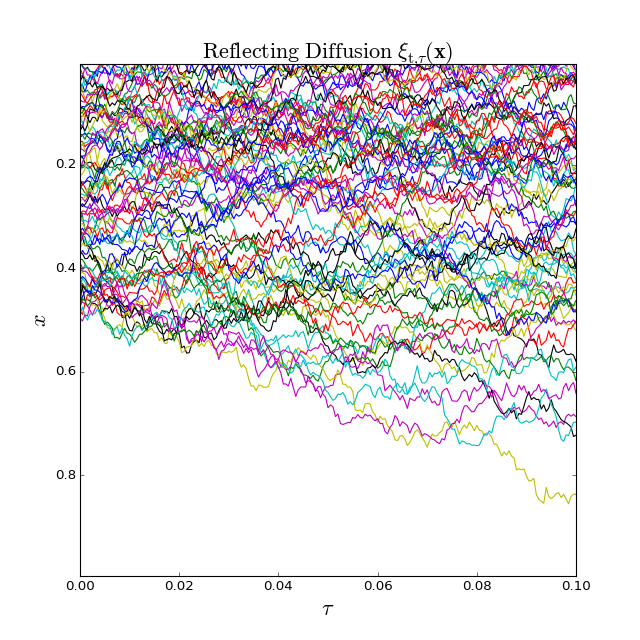

<IPython.core.display.Javascript object>


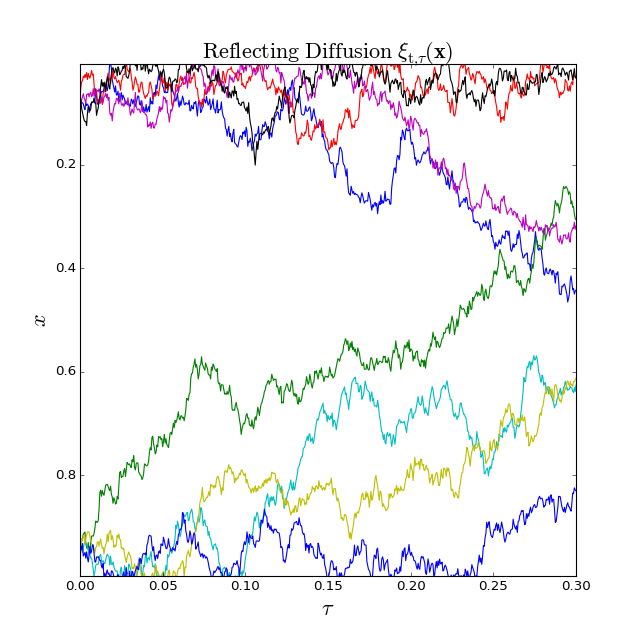

In [30]:
molecular_traj = xfull

particleindx = -1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(npoints/2):
    ax.plot(tau,molecular_traj[:, i, particleindx, 0])
ax.set_ylim([Top-10*eps,Bottom+10*eps])
ax.set_xlim([0,0.1])
ax.set_title('$\\rm Reflecting\ Diffusion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

space_indx1 = 10
space_indx2 = -10
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(nparticles/5):
    ax.plot(tau,molecular_traj[:, space_indx1, i, 0])
    ax.plot(tau,molecular_traj[:, space_indx2, i, 0])
ax.set_ylim([Top-10*eps,Bottom+10*eps])
ax.set_xlim([0,0.3])
ax.set_title('$\\rm Reflecting\ Diffusion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

<IPython.core.display.Javascript object>


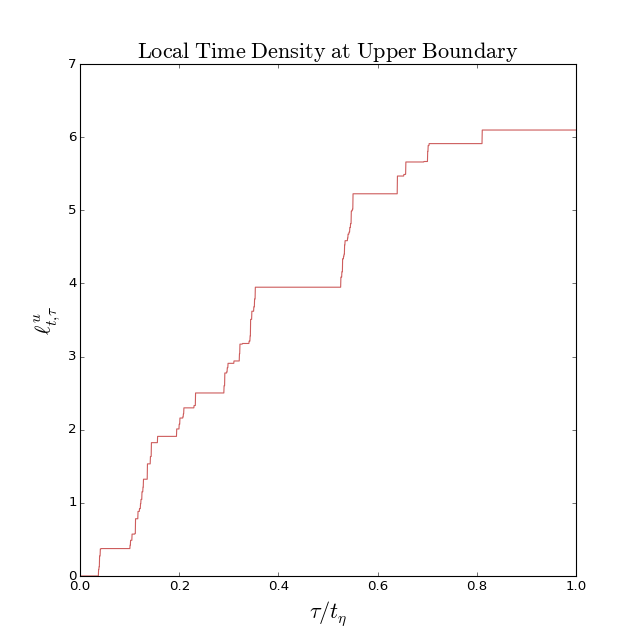

In [37]:
molecular_traj = xfull
space_indx = -2
particleindx = 2
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,localtimeR[:, space_indx, particleindx],color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Upper\ Boundary$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

<IPython.core.display.Javascript object>


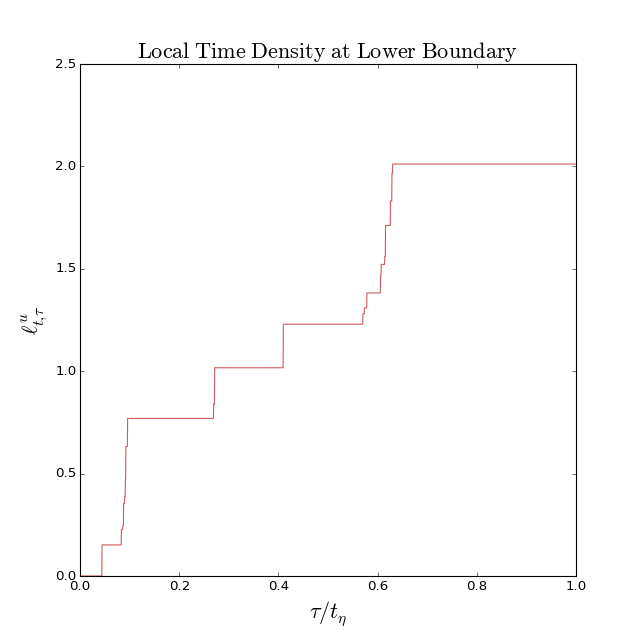

In [38]:
molecular_traj = xfull
space_indx = 2
particleindx = 9
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,localtimeL[:, space_indx, particleindx],color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Lower\ Boundary$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

In [40]:
from scipy.special import erf
def localTimePDF(x):
    return 2*erf(x/4*(Bottom-Top))-1

time_index = len(t)-1
ELL   = np.zeros(npoints)
ELR   = np.zeros(npoints)
VarLL = np.zeros(npoints)
VarLR = np.zeros(npoints)
CovL  = np.zeros(npoints)
for i in range(npoints):
    localtimeL_Ave = np.average(localtimeL, axis = 2)
    localtimeR_Ave = np.average(localtimeR, axis = 2)
    localtimeL_Var = np.average(localtimeL**2, axis = 2)         - localtimeL_Ave**2
    localtimeR_Var = np.average(localtimeR**2, axis = 2)         - localtimeR_Ave**2
    localtime_Cov  = np.average(localtimeR*localtimeL, axis = 2) - localtimeR_Ave*localtimeL_Ave
    ELL[i]   = localtimeL_Ave[time_index, i]
    ELR[i]   = localtimeR_Ave[time_index, i]
    VarLL[i] = localtimeL_Var[time_index, i]
    VarLR[i] = localtimeR_Var[time_index, i]
    CovL[i]  = localtime_Cov[time_index,  i]

<IPython.core.display.Javascript object>


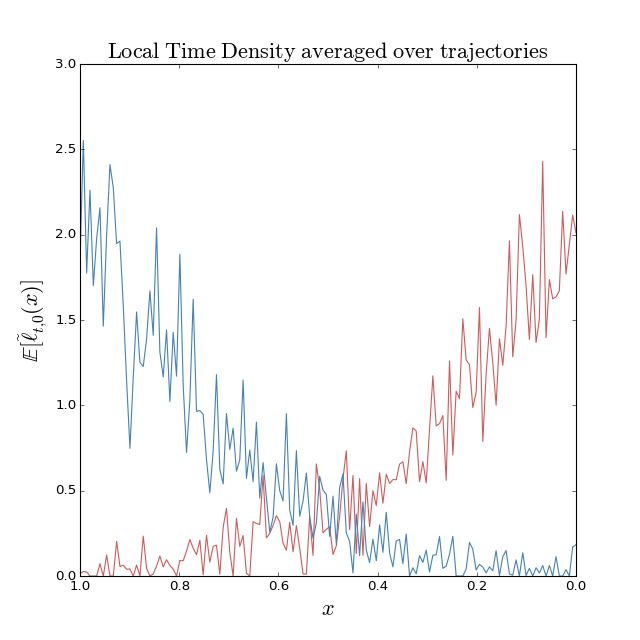

<IPython.core.display.Javascript object>


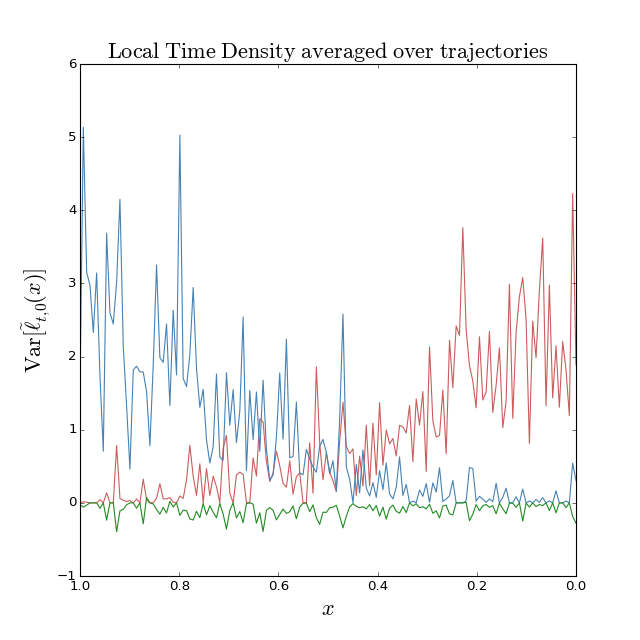

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, ELL, color = 'Indianred')
ax.plot(xx, ELR, color = 'Steelblue')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Local\ Time\ Density\ averaged \ over \ trajectories$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\mathbb{E}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, VarLL, color = 'Indianred')
ax.plot(xx, VarLR, color = 'Steelblue')
ax.plot(xx, CovL, color = 'Forestgreen')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Local\ Time\ Density\ averaged \ over \ trajectories$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('${\\rm Var}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)

<IPython.core.display.Javascript object>


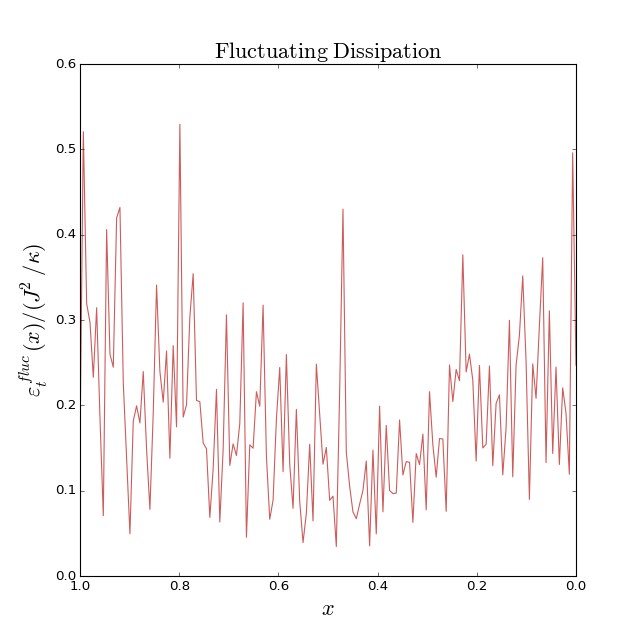

In [42]:
J=1
FluctuatingDissipation = VarLL + VarLR - CovL
FluctuatingDissipation = FluctuatingDissipation/(J**2/kappa)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, FluctuatingDissipation, color = 'Indianred')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Fluctuating\ Dissipation$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\varepsilon_t^{fluc}(x)/(J^2/\kappa)$', fontsize=20)

Use Takac's Eq.(3) as a test on the numerics. For a Brownian motion started   
at $x_0>0$ and reflected at 0, the PDF $p(\ell)$ of the local time density at 0 is 

$ p(\ell)=   \sqrt{\frac{\kappa}{\pi t}} e^{-(x_0+2\kappa \ell)^2/4\kappa t} \eta(\ell) + [2\Phi_{\kappa,t}(x_0)-1] \delta(\ell)$

with $\Phi_{\kappa,t}(x_0)=\frac{1}{\sqrt{4\kappa t}} \int_{-\infty}^{x_0} dy\  e^{-y^2/4\kappa t}$.
